<a href="https://colab.research.google.com/github/Brandonff13/IdentificacionModelos/blob/master/deepdmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep DMD / Koopman Autoencoder
Se construye una serie temporal de estados:
$$x_k \in \mathbb{R}^4n, \quad k=0,...,T-1$$
donde cada $x_k$ es el vector concatenado con todas las poblaciones de
$S,E,I,R$ en los $n$ parches. Se crean pares consecutivos:
$$(x_k,x_{k+1}),$$
que representan la evolución real del sistema. Se busca un espacio latente $\mathbb{R}^m$ donde la dinámica sea lineal, se define un encoder no lineal $E_\theta$ (red neuronal) y un decoder no lineal $D_\phi$:
$$z_k=E_\theta(x_k)\in \mathbb{R}^r, r\ll 4n,$$
$$\hat{x}_k=D_\phi(z_k),$$
$$z(t+\Delta t)=K z(t) \quad \text{(evolución lineal)}.$$
Arquitectura del modelo:

Encoder: $E_\theta(x)=W_2 \sigma(W_1 x +b_1)+b_2$.

Decoder: $D_\phi(z)=W_4 \sigma(W_3 z +b_3)+b_4$.

En el espacio de $z$, se asume que la evolución es lineal:
$$z_{k+1}\approx Kz_k,$$
donde $K\in \mathbb{R}^{r \times r}$ es el operador de Koopman. Esto es la aproximación de Koopman: una dinámica no lineal $x_{k+1}=F(x_k)$ se convierte en lineal en un espacio extendido:
$$E_\theta(F(x)) \approx K E_\theta(x).$$
El entrenamiento del autoencoder busca minimizar dos errores:
- Error de reconstrucción. Asegura que el autoencoder represente bien el estado: $$\mathcal{L}_{rec}=||D_\phi(E_\theta(x_k))-x_k||^2.$$
- Error de dinámica en el espacio latente. Asegura que $K$ capture la evolución temporal: $$\mathcal{L}_{dyn}=||Kz_k-z_{k+1}||^2.$$

Se descompone el operador de Koopman: $$K=V\Lambda V^{-1},$$
donde $Λ$ es la matriz diagonal de valores propios de $λ_i$ y $V$ es la matriz de vectores propios (modos de Koopman).

Los modos en el espacio de estado se obtienen como:
$$\Psi = D_\phi(V)=[D_\phi(v_1),...,D_\phi(v_r)],$$
cada modo $D_\phi(v_j)$ representa u  patrón espacial que evoluciona exponencialmente:
$$D_\phi(v_j)(t)=e^{λ_jt}D_\phi(v_j)(0).$$
Una vez entrenado, la matriz $K$ cumple el rol de un operador de Koopman reducido:
- Sus autovalores $λ_j$ indican tasas de crecimiento/decadencia y frecuencias en el espacio latente.
- Sus autovectores (y los modos decodificados con el decoder) te dicen qué combinación de parches y variables (S,E,I,R) están asociadas a cada dinámica.

La reconstrucción se obtiene como:
$$\hat{x}(t)=D_ϕ(K^tE_θ(x(0)))=D_ϕ(V\Lambda^tV^{-1}E_θ(x(0))).$$




Epoch 1/120 loss=0.180161
Epoch 30/120 loss=0.000593
Epoch 60/120 loss=0.004910
Epoch 90/120 loss=0.000687
Epoch 120/120 loss=0.000897


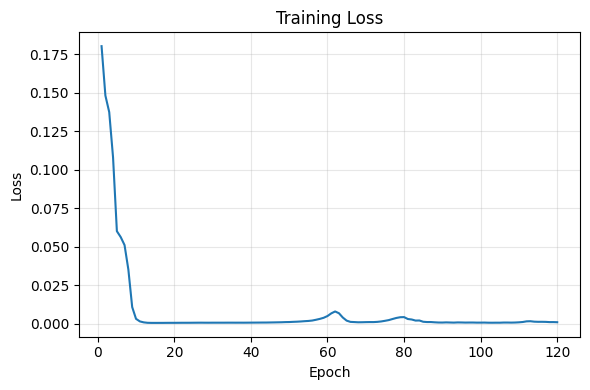

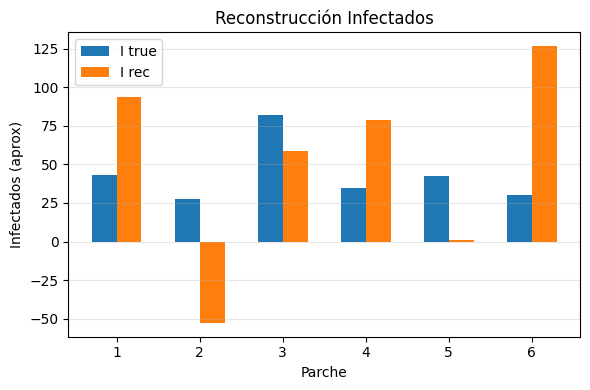

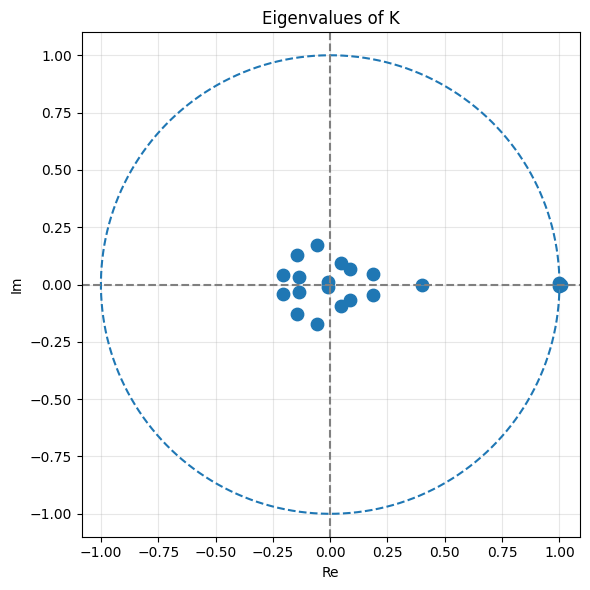

/tmp/ipython-input-65917631.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  W_t = torch.from_numpy(W.T.astype(np.float32))


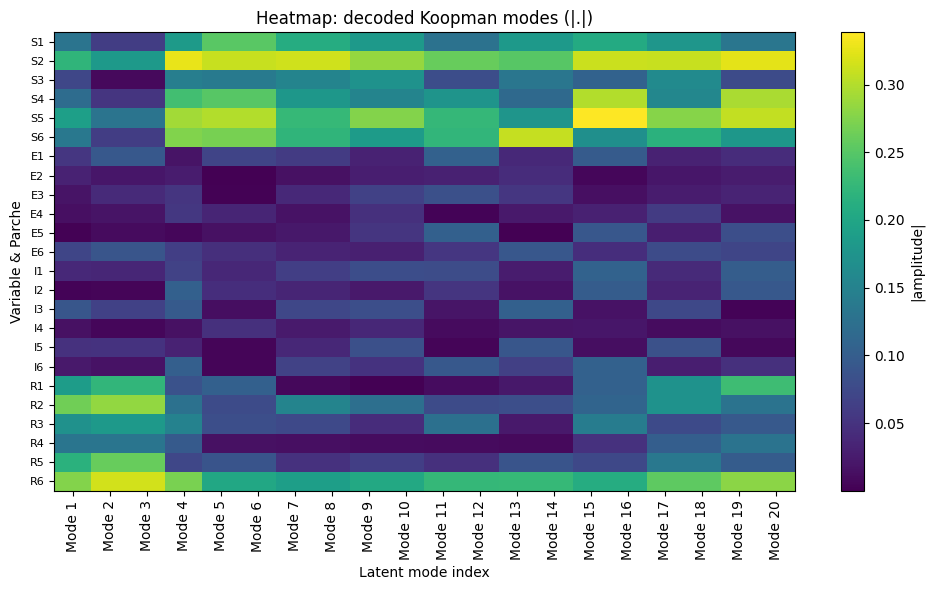

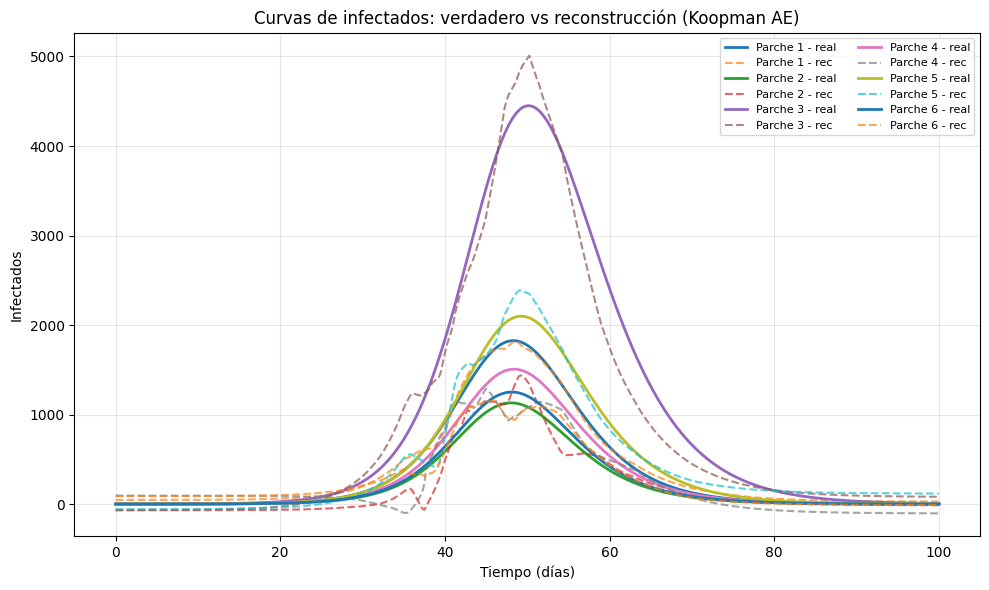

In [ ]:
# Koopman Autoencoder
# Requiere: numpy, networkx, scipy, matplotlib, torch

import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------- SEIR simulator (idéntico en forma a tu código) ----------
params = {
    'beta_range': (0.59, 1.68),
    'kappa_range': (0.33, 0.5),
    'gamma_range': (0.1, 1.0),
    'epsilon': 1/8,
    'N_range': (15000, 35000)
}

def generar_red(n, tipo='BA'):
    if tipo == 'BA':
        G = nx.barabasi_albert_graph(n, m=2)
    else:
        G = nx.erdos_renyi_graph(n, p=0.5)
    P = nx.to_numpy_array(G).astype(float)
    for i in range(n):
        P[i,i] = 0.9
        P[i,:] /= P[i,:].sum()
    return P

def inicializar_parches(n):
    N = np.random.randint(*params['N_range'], size=n)
    S0 = N.astype(float).copy()
    E0 = np.zeros(n)
    I0 = np.zeros(n)
    R0 = np.zeros(n)
    S0[0] -= 2
    E0[0] = 1
    I0[0] = 1
    beta = np.random.uniform(*params['beta_range'], size=n)
    kappa = np.random.uniform(*params['kappa_range'], size=n)
    gamma = np.random.uniform(*params['gamma_range'], size=n)
    return N, S0, E0, I0, R0, beta, kappa, gamma

def construir_beta_mat(beta, P, N):
    n = len(beta)
    w = P.T.dot(N)
    beta_mat = np.zeros((n,n))
    for k in range(n):
        beta_mat += beta[k] * np.outer(P[:,k], P[:,k]) / w[k]
    return beta_mat

def modelo_SEIR(t, y, n, beta_mat, kappa, gamma, epsilon):
    S, E, I, R = y[:n], y[n:2*n], y[2*n:3*n], y[3*n:]
    inf = beta_mat.dot(I + epsilon * E)
    dSdt = -S * inf
    dEdt = S * inf - kappa * E
    dIdt = kappa * E - gamma * I
    dRdt = gamma * I
    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

def simular_red_SEIR(n=6, tipo_red='BA', t_max=40, n_t=401, seed=None):
    if seed is not None:
        np.random.seed(seed)
    P = generar_red(n, tipo_red)
    N, S0, E0, I0, R0, beta, kappa, gamma = inicializar_parches(n)
    beta_mat = construir_beta_mat(beta, P, N)
    y0 = np.concatenate([S0, E0, I0, R0])
    t_eval = np.linspace(0, t_max, n_t)
    sol = solve_ivp(modelo_SEIR, (0, t_max), y0,
                    args=(n, beta_mat, kappa, gamma, params['epsilon']),
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    return {'t': sol.t, 'S': sol.y[:n], 'E': sol.y[n:2*n], 'I': sol.y[2*n:3*n], 'R': sol.y[3*n:], 'N': N, 'P': P}

# ---------- Build dataset ----------
n_parches = 6
res = simular_red_SEIR(n=n_parches, tipo_red='BA', t_max=100, n_t=401, seed=0)
X = np.vstack([res['S'], res['E'], res['I'], res['R']]).astype(np.float32)
scale = np.concatenate([res['N'], res['N'], res['N'], res['N']]).astype(np.float32)
X_scaled = X / scale[:, None]
Xk = X_scaled[:, :-1].T
Xk1 = X_scaled[:, 1:].T

# Torch tensors / loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xt = torch.from_numpy(Xk).to(device)
Xt1 = torch.from_numpy(Xk1).to(device)
dataset = TensorDataset(Xt, Xt1)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ---------- Koopman Autoencoder (ligero) ----------
state_dim = Xk.shape[1]   # 4n
latent_dim = 20            # pequeño para rapidez
class KoopmanAE(nn.Module):
    def __init__(self, sdim, ldim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(sdim, 64), nn.ReLU(), #Capa 1
            nn.Linear(64, ldim) #Capa 2
        )
        self.decoder = nn.Sequential(
            nn.Linear(ldim, 64), nn.ReLU(),
            nn.Linear(64, sdim)
        )
        self.K = nn.Parameter(torch.randn(ldim, ldim) * 0.05)
    def forward(self, x):
        z = self.encoder(x)
        z_next_pred = z @ self.K.T
        x_rec = self.decoder(z)
        return x_rec, z, z_next_pred

model = KoopmanAE(state_dim, latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()
n_epochs = 120
alpha = 1.0

loss_hist = []
for ep in range(1, n_epochs+1):
    ep_loss = 0.0
    for xb, xb1 in loader:
        opt.zero_grad()
        xrec, z, znext_pred = model(xb)
        with torch.no_grad():
            znext_true = model.encoder(xb1)
        loss = mse(xrec, xb) + alpha * mse(znext_pred, znext_true)
        loss.backward()
        opt.step()
        ep_loss += loss.item() * xb.size(0)
    ep_loss /= len(dataset)
    loss_hist.append(ep_loss)
    if ep % 30 == 0 or ep==1:
        print(f"Epoch {ep}/{n_epochs} loss={ep_loss:.6f}")

# ---------- Plots (each figura por separado) ----------
import numpy.linalg as LA

# 1) Loss
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(loss_hist)+1), loss_hist)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 2) Reconstrucción: Infectados (single snapshot)
idx = 100
x_true = Xk[idx]
x_rec = model.decoder(model.encoder(torch.from_numpy(x_true).unsqueeze(0).to(device))).cpu().detach().numpy().ravel()
n = n_parches
I_true = x_true[2*n:3*n] * res['N']
I_rec = x_rec[2*n:3*n] * res['N']

plt.figure(figsize=(6,4))
plt.bar(np.arange(1,n+1)-0.15, I_true, width=0.3, label='I true')
plt.bar(np.arange(1,n+1)+0.15, I_rec, width=0.3, label='I rec')
plt.xlabel("Parche"); plt.ylabel("Infectados (aprox)"); plt.title("Reconstrucción Infectados")
plt.legend(); plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# 3) Eigenvalues of K
K_cpu = model.K.detach().cpu().numpy()
eigvals, eigvecs = LA.eig(K_cpu)
plt.figure(figsize=(6,6))
plt.scatter(eigvals.real, eigvals.imag, s=80)
theta = np.linspace(0,2*np.pi,200)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--')
plt.axhline(0, color='gray', linestyle='--'); plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Re"); plt.ylabel("Im"); plt.title("Eigenvalues of K"); plt.axis('equal'); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 4) Heatmap of decoded modes
W = eigvecs
W_t = torch.from_numpy(W.T.astype(np.float32))
modes_state = model.decoder(W_t).cpu().detach().numpy()  # shape (latent_dim, state_dim)
modes_abs = np.abs(modes_state.T)
plt.figure(figsize=(10,6))
plt.imshow(modes_abs, aspect='auto')
plt.colorbar(label='|amplitude|')
labels = []
for v in ['S','E','I','R']:
    for j in range(n_parches):
        labels.append(f"{v}{j+1}")
plt.yticks(np.arange(len(labels)), labels, fontsize=8)
plt.xticks(np.arange(latent_dim), [f"Mode {i+1}" for i in range(latent_dim)], rotation=90)
plt.xlabel("Latent mode index"); plt.ylabel("Variable & Parche")
plt.title("Heatmap: decoded Koopman modes (|.|)"); plt.tight_layout(); plt.show()

def graficar_curvas_infectados(res, model, scale, n_parches=6, device='cpu'):
    """
    Grafica infectados verdaderos vs reconstruidos (Koopman AE).
    - res: resultados de la simulación SEIR
    - model: Koopman Autoencoder entrenado
    - scale: vector de normalización (para desescalar)
    - n_parches: número de parches
    - device: 'cpu' o 'cuda'
    """
    with torch.no_grad():
        # Estado completo normalizado
        X_scaled = np.vstack([res['S'], res['E'], res['I'], res['R']]) / scale[:, None]
        X_tensor = torch.from_numpy(X_scaled.T.astype(np.float32)).to(device)
        # Reconstrucción
        X_rec = model.decoder(model.encoder(X_tensor)).cpu().numpy().T
    # Desescalar
    X_rec = X_rec * scale[:, None]

    # Infectados verdaderos y reconstruidos
    I_true = res['I']
    I_rec = X_rec[2*n_parches:3*n_parches, :]

    plt.figure(figsize=(10, 6))
    for i in range(n_parches):
        plt.plot(res['t'], I_true[i], label=f"Parche {i+1} - real", lw=2)
        plt.plot(res['t'], I_rec[i], '--', label=f"Parche {i+1} - rec", alpha=0.7)
    plt.xlabel("Tiempo (días)")
    plt.ylabel("Infectados")
    plt.title("Curvas de infectados: verdadero vs reconstrucción (Koopman AE)")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
graficar_curvas_infectados(res, model, scale, n_parches=n_parches, device=device)


El heatmap muestra $|Ψ|$, donde cada columna representa cómo un modo latente específico se manifiesta en las diferentes variables y parches.